In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV
rcParams.update({'figure.autolayout': True})

# 1. Figure out your question

Our questions was given to us by our sponsor company Neighbor. They asked us to figure out how long a reservation would last on their website. See <a>https://www.neighbor.com/</a> for more background information on the company.

# 2. Obtain a Labelled Dataset

This dataset is sourced from six different data tables given to us by the company. Most of the code in this section involves combining and cleaning the data to create useable labelled data for our models.

In [35]:
# Read in Data Tables

# listings.csv
listings = pd.read_csv('C:\\Users\\ben1c\\Projects\\Econ 484\\Final Project\\listings.csv')
# users.csv
users = pd.read_csv('C:\\Users\\ben1c\\Projects\\Econ 484\\Final Project\\users.csv')
# reservations.csv
reservations = pd.read_csv('C:\\Users\\ben1c\\Projects\\Econ 484\\Final Project\\reservations.csv')
# risting_metadata.csv
listingmeta = pd.read_csv('C:\\Users\\ben1c\\Projects\\Econ 484\\Final Project\\listing_metadata.csv')
# photos.csv
photos = pd.read_csv('C:\\Users\\ben1c\\Projects\\Econ 484\\Final Project\\photos.csv')
# user_metadata.csv
usermeta = pd.read_csv('C:\\Users\\ben1c\\Projects\\Econ 484\\Final Project\\user_metadata.csv')

In [36]:
# Drop all duplicates, deleted posts or any that aren't published
listings.drop_duplicates()
listings = listings[listings.status == 'Published']
listings = listings[listings['deleted'] != 'True']

# Return user data from hosts only
users = users[users['is_host']==True]

In [37]:
# Creates new column with Description Length Boolean
listings['Description Length'] = np.where(listings['summary'].str.len()>=30, '1', '0')

# Creates new column with Title Length Boolean
listings['Title Length'] = np.where((listings['listing_name'].str.len()>=10), 1, 0)

# Create Storage Type Category
listings['Storage Type'] = listings['storage_type'].values

# Create Accessibility Category
listings['Accessibility'] = listings['access'].values

# Create Price Per Square Ft
listings['Price Per SQFT'] = (listings['monthly_price'].values)/(listings['width'].values * listings['length'].values)

# Create Day Posted
listings['Day Posted'] = pd.to_datetime(listings['created_at']).dt.dayofweek

# Create Month Posted
listings['Month Posted'] = pd.to_datetime(listings['created_at']).dt.month

In [38]:
#USER METADATA

#picking relevant columns
dfusermeta = pd.DataFrame(usermeta, columns=['id','user_id','key','value'])
df12 = pd.DataFrame(usermeta, columns=['id','user_id','key','value'])

#New column with superhost level inputted
dfusermeta['Superhost Level'] = dfusermeta[dfusermeta['key']=='superhost_level']['value'].astype(int)
df12['Superhost Level'] = np.where(dfusermeta['key']=='superhost_level',dfusermeta['value'],'0')
df123 = df12.loc[df12['Superhost Level']!='0']
users = pd.merge(users, df123[['user_id', 'Superhost Level']], left_on='id', right_on='user_id', how='left')


#Pull in enterprise status
dfusermeta['Enterprise'] = dfusermeta[dfusermeta['key']=='enterprise_account']['value']
df12['Enterprise'] = np.where(dfusermeta['key']=='enterprise_account', '1', '0')
df124 = df12.loc[df12['Enterprise']!='0']
users = pd.merge(users, df124[['user_id', 'Enterprise']], left_on='id', right_on='user_id', how='left')

In [39]:
#LISTING METADATA
df1 = pd.DataFrame(listingmeta, columns= ['id','listing_id','key','value',])
df23 = pd.DataFrame(listingmeta, columns= ['id','listing_id','key','value',])

Price score ranges from 0 to 1 with .5 being the best score. We manipulated price score such that its range is from -.5 to 0 where a value of 0 represents the best possible score and a value of -.5 means that the assigned price score was .5 away form the ideal price score of .5. Therefore, if you were given a score of .7 (your price is higher than our recommendation) then the value in the column would read in as -.2 because you were .2 away from the ideal price score. We did this to make the coefficient on price score easier to understand.

In [40]:
#Pull price score data
df23['Price Score'] = np.where(df1['key']=='price_score',df1['value'],'0')
df234 = df23.loc[df23['Price Score']!='0']
df234['Price Score'] = -(abs(df234['Price Score'].astype(float) + -.5))

listings = pd.merge(listings, df234[['listing_id', 'Price Score']], left_on='id', right_on='listing_id', how='left')

#First Month Discount
df23['Discount'] = np.where(df1['key']=='first_month_discount',df1['value'],'0')
df234 = df23.loc[df23['Discount']!='0']
listings = pd.merge(listings, df234[['listing_id', 'Discount']], left_on='id', right_on='listing_id', how='left')

#Pull manual score data
df23['Manual Score'] = np.where(df1['key']=='manual_score',df1['value'],'0')
df234 = df23.loc[df23['Manual Score']!='0']
listings = pd.merge(listings, df234[['listing_id', 'Manual Score']], left_on='id', right_on='listing_id', how='left')

In [41]:
#Pull feature data
dffeat = pd.DataFrame(listingmeta, columns= ['id','listing_id','key','value'])
dffeat = dffeat[dffeat['key']=='features']
dffeat.drop('key', axis = 1, inplace=True)

dffeat1 = dffeat['value'].str.split(pat=",",expand=True)      
dffeat1 = pd.get_dummies(dffeat1.apply(pd.Series).stack()).sum(level=0)
dffeat1['id'] = dffeat['listing_id']

Some of the features are listed twice in the original dataframe so we will replace any values of 2 with a 1

In [42]:
dffeat1.replace(2, 1, inplace=True)

In [43]:
listings = pd.merge(listings, dffeat1, on='id', how='left')

In [44]:
#USERS
#picking relevant columns
dfusers = pd.DataFrame(users, columns= ['id','bio','is_host','profile_photo_id' , 'lead_source'])

#return user data from hosts only
dfusers = dfusers[dfusers['is_host']==True]

#if they have a bio, counts the number of characters
dfusers['bio length'] = np.where(dfusers['bio'].isna(), 0, 1)

#Add new column, if they have profile pic then '1' else '0'
dfusers['Profile Photo'] = np.where(dfusers['profile_photo_id'].notnull().values,'1','0')

In [45]:
#PHOTOS

#picking relevant columns
dfphoto = pd.DataFrame(photos, columns= ['id','imageable_type','imageable_id','filename', 'deleted'])
dfphoto2 = pd.DataFrame(photos, columns= ['id','imageable_type','imageable_id','filename', 'deleted'])

#returning only undeleted listing photo data
dfphoto = dfphoto[dfphoto['imageable_type']=='Listing']

#insert new column for streetview and label with 1 and 0 for rows with streetview
dfphoto2['streetview'] = np.where((dfphoto2['filename']=='streetView') |(dfphoto2['filename']=='streetview'),'1','0')


dfphoto3 = dfphoto2.loc[dfphoto2['streetview']=='1']
dfphoto3 = dfphoto3[dfphoto3['deleted']==False]

#Add streetview count on listing df
listings = pd.merge(listings, dfphoto3[['imageable_id','streetview']], left_on='id', right_on='imageable_id', how='left')


#count number of pictures for a listing
dfphoto['Frequency'] = dfphoto.groupby('imageable_id')['imageable_id'].transform('count')

#drop duplicate rows for the same listing
dfphoto.drop_duplicates('imageable_id', inplace=True)
dfphoto = dfphoto[dfphoto['deleted']==False]

#Add number of pictures on a listing to listing df
listings = pd.merge(listings, dfphoto[['imageable_id','Frequency']], left_on='id', right_on='imageable_id', how='left')

In [46]:
# Merge the listing and user data together
listings = pd.merge(listings,
                    users,
                    left_on='user_id',
                    right_on='id',
                    how='left')

In [47]:
# Get Reservation info
reservations.drop_duplicates(inplace=True)


In [48]:
# Create Reservation Length Status
listings = pd.merge(listings, reservations[['listing_id', 'Reservation_Length']], left_on='id_x', right_on='listing_id', how='left')

In [49]:
finaldf = pd.DataFrame()

# Bring in Listing Info
finaldf['Listing-ID'] = listings['id_x']
finaldf['Accessibility'] = listings['Accessibility']
finaldf['Storage Type'] = listings['Storage Type']
finaldf['Title Length'] = listings['Title Length']
finaldf['Description Length'] = listings['Description Length']
finaldf['Indoor'] = listings['indoor']
finaldf['Day Posted'] = listings['Day Posted']
finaldf['Month Posted'] = listings['Month Posted']
finaldf['Photos of the Space'] = listings['Frequency']
finaldf['Streetview'] = listings['streetview']
finaldf['Discount'] = listings['Discount']
finaldf['Price Per SQFT'] = listings['Price Per SQFT']

# Bring in Host Info
finaldf['Bio Included'] = dfusers['bio length']
finaldf['Profile Photo'] = dfusers['Profile Photo']
finaldf['Phone Verified'] = listings['phone_verified']
finaldf['Photo ID Verified'] = listings['photo_id_verified']
finaldf['Superhost Level'] = listings['Superhost Level']
finaldf['Camera'] = listings['camera']
finaldf['Climate Controlled'] = listings['climate_controlled']
finaldf['Lockable'] = listings['is_lockable']
finaldf['No Pets'] = listings['no_pets']
finaldf['No Stairs'] = listings['no_stairs']
finaldf['Private Entrance'] = listings['private_entrance']
finaldf['Smoke Detectors'] = listings['smoke_detectors']
finaldf['Smoke Free'] = listings['smoke_free']
finaldf['Enterprise'] = listings['Enterprise']

# Bring in Review info
finaldf['Manual Score'] = listings['Manual Score']
finaldf['Price Score'] = listings['Price Score']

# Add Reserved Info
finaldf['Reservation Length'] = listings['Reservation_Length']
finaldf.dropna(subset=['Reservation Length'], inplace=True)

In [50]:
finaldf.drop_duplicates(inplace=True)
missingdata = pd.DataFrame()
missingdata['total'] = finaldf.isnull().sum()
missingdata['percent'] = missingdata['total'] / len(missingdata)
missingdata.sort_values('percent', ascending = False).head(10)

,total,percent
Enterprise,1223,42.172414
Streetview,1118,38.551724
Photos of the Space,321,11.068966
Discount,307,10.586207
No Pets,104,3.586207
Climate Controlled,104,3.586207
Lockable,104,3.586207
Smoke Free,104,3.586207
Smoke Detectors,104,3.586207
Private Entrance,104,3.586207


# Cleaning missing values
#### The following are our reasoning on filling these missing values with zeroes

Discount-maybe it didn't exist in the beginning so some of the early ones are are NaN, replace t/f with TRUE/FALSE, then Fill with ZERO  
Features - 108 are missing for them all and it appears that they are the same listings, seems like they are outside so it probably means that they just don't have any of those features. FILL WITH ZERO  
Price Score- I don't see anything special. DROP ROW  
Manual Score- I don't see anything special. DROP ROW  
Phone Verified- Fill with zeros  
Superhost level - FIll with Zeros  
Bio Length- Fill with Zero  
Photos of Space- FIll with Zero, because there are no zero values  
Streetview- Fill with 0 becuase they don't have it.  

In [51]:
finaldf.replace('true', 1, inplace=True)
finaldf.replace('false', 0, inplace=True)
finaldf.replace('True', 1, inplace=True)
finaldf.replace('False', 0, inplace=True)
finaldf.replace('TRUE', 1, inplace=True)
finaldf.replace('FALSE', 0, inplace=True)
finaldf.replace('f', 0, inplace=True)
finaldf.replace('t', 1, inplace=True)
finaldf.replace(False, 0, inplace=True)
finaldf.replace(True, 1, inplace=True)

In [52]:
finaldf = finaldf.fillna(0)
finaldf = finaldf.dropna()

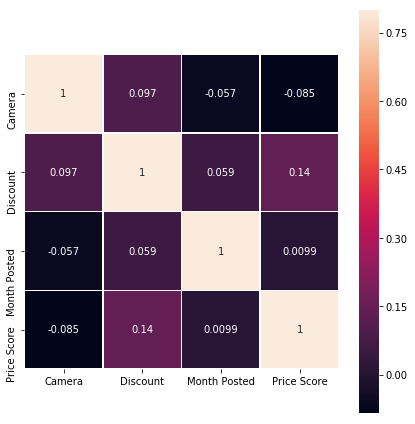

In [53]:
corrl = pd.DataFrame(finaldf, columns=['Camera', 'Manual Score', 'Enterprise',
                                       'Discount', 'Month Posted', 'Superhost Level', 'Price Score'])
correlation_map = corrl.corr()
# correlation_map
plt.figure(figsize=(6,6))
sns.heatmap(correlation_map, vmax=.8, square=True, annot=True, linewidth=.5)

Take out rows where Reserevation Length = 0

In [54]:
finaldf = finaldf.fillna(0)
missingdata = pd.DataFrame()
missingdata['total'] = finaldf.isnull().sum()
missingdata['percent'] = missingdata['total'] / len(missingdata)
missingdata.sort_values('percent', ascending = False).head(5)

,total,percent
Listing-ID,0,0.0
Photo ID Verified,0,0.0
Price Score,0,0.0
Manual Score,0,0.0
Enterprise,0,0.0


In [55]:
dummies = ['Storage Type', 'Accessibility']
finaldf = pd.get_dummies(finaldf, columns=dummies)

### Code for creating summary statistics

In [56]:
finaldfsumstat = pd.DataFrame(finaldf, columns=['Day Posted', 'Month Posted', 'Photos of the Space',
       'Superhost Level', 'Manual Score',
       'Price Score', 'Reservation Length'])
finaldfsumstat.describe().round(2).to_clipboard(excel=True)

In [57]:
finaldfsumstat = pd.DataFrame(finaldf, columns=['Indoor',
       'Phone Verified', 'Photo ID Verified', 'Superhost Level', 'Camera',
       'Climate Controlled', 'Lockable', 'No Pets', 'No Stairs',
       'Private Entrance', 'Smoke Detectors', 'Smoke Free',
       'Discount',])
finaldfsumstat.describe().round(2).to_clipboard(excel=True)

In [58]:
X = pd.DataFrame(finaldf, columns = ['Title Length', 'Description Length', 'Indoor',
       'Day Posted', 'Month Posted', 'Photos of the Space', 'Streetview',
       'Discount', 'Bio Included', 'Profile Photo', 'Phone Verified',
       'Photo ID Verified', 'Superhost Level', 'Camera', 'Climate Controlled',
       'Lockable', 'No Pets', 'No Stairs', 'Private Entrance',
       'Smoke Detectors', 'Smoke Free', 'Enterprise', 'Manual Score',
       'Price Score', 'Storage Type_Basement',
       'Storage Type_Bedroom', 'Storage Type_Garage', 'Storage Type_Lot',
       'Storage Type_Other', 'Storage Type_RV Pad',
       'Storage Type_Storage Facility', 'Storage Type_Warehouse',
       'Accessibility_24/7', 'Accessibility_Business Hours',
       'Accessibility_By Appointment Only'])

y = pd.DataFrame(finaldf, columns = ['Reservation Length'])

# 3. Split into Test and Training Set

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 4. Pick an Model
# 5. Use CrossFold Validation to pick parameters
# 6. Fit model to training data
# 7. Test the model on test data

In [60]:
lasso = Lasso()
lasso = lasso.fit(X_train, y_train)
cross = cross_validate(lasso, X, y, cv=3, scoring='neg_mean_squared_error', return_estimator=True)

print('Mean MSE:', cross['test_score'].mean())

Mean MSE: -23631.74890901227


In [61]:
feature_imp = sorted(list(zip(X.columns, abs(lasso.coef_))), key=lambda x: x[1], reverse=True)
feature_imp[:5]

[('Manual Score', 81.10719162106928),
 ('Discount', 77.23051718287262),
 ('No Stairs', 44.42622018318442),
 ('Enterprise', 36.02695928951823),
 ('Smoke Free', 24.823243769755997)]

# 8. Do steps 4-7 on another model

In [62]:
rfr = RandomForestRegressor(max_features='sqrt')

gridsearch = GridSearchCV(rfr, {'max_depth': [50, 60], 'n_estimators': [300, 350, 400]}, cv=3)

gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))

y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print("GridSearch MSE:")
print("Train Accuracy: {}\tTest Accuracy: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Best Params: {'max_depth': 60, 'n_estimators': 400}
GridSearch MSE:
Train Accuracy: 5251.133602655502	Test Accuracy: 20862.185317696458


In [63]:
rfr = RandomForestRegressor(max_features='sqrt', max_depth=50, n_estimators=400)
rfr.fit(X_train, y_train)
y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print("GridSearch MSE:")
print("Train Accuracy: {}\tTest Accuracy: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))
feature_imp = sorted(list(zip(X.columns, rfr.feature_importances_)), key=lambda x: x[1], reverse=True)
# pd.Series([x[1] for x in feature_imp[:]], index=[x[0] for x in feature_imp[:]]).plot(kind='bar', figsize=(14, 4))
feature_imp[:5]

GridSearch MSE:
Train Accuracy: 5251.133602655502	Test Accuracy: 20862.185317696458


[('Month Posted', 0.1058775889641792),
 ('Price Score', 0.10511395890558418),
 ('Photos of the Space', 0.0809044560366193),
 ('Manual Score', 0.07752572709592136),
 ('Profile Photo', 0.06913415515639439)]

# Data Visualization for Paper

Max depth chart with random forest max depth on x Axis and MSE on y
with MSE for training and test set

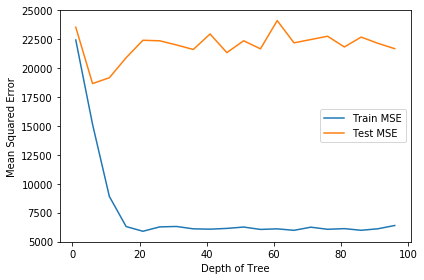

In [64]:
mse_train = []
mse_test = []
max_depth = range(1, 101, 5)
for i in max_depth:
    rfr = RandomForestRegressor(max_features='sqrt', max_depth=i)
    rfr.fit(X_train, y_train)
    y_pred_train = rfr.predict(X_train)
    y_pred_test = rfr.predict(X_test)
    mse_train.append(mean_squared_error(y_train, y_pred_train))
    mse_test.append(mean_squared_error(y_test, y_pred_test))

    
    
ax = sns.lineplot(max_depth, mse_train)               
ax = sns.lineplot(max_depth, mse_test)
ax.set(xlabel='Depth of Tree', ylabel='Mean Squared Error')
plt.legend(labels=['Train MSE', 'Test MSE'])
